# Shafts

In this notebook, the shafts that connect the groundfloors, entrances and all floors above are being generated in a lattice.

## 0. Initialization

### 0.1. Load required libraries

In [13]:
import os
import topogenesis as tg
import pyvista as pv
import trimesh as tm
import numpy as np
import networkx as nx
import pandas as pd
from sklearn.cluster import KMeans
np.random.seed(0)
import copy

In [14]:
# extra import function
def lattice_from_csv(file_path):
    # read metadata
    meta_df = pd.read_csv(file_path, nrows=3)

    shape = np.array(meta_df['shape'])
    unit = np.array(meta_df['unit'])
    minbound = np.array(meta_df['minbound'])

    # read lattice
    lattice_df = pd.read_csv(file_path, skiprows=5)

    # create the buffer
    buffer = np.array(lattice_df['value']).reshape(shape)

    # create the lattice
    l = tg.to_lattice(buffer, minbound=minbound, unit=unit)

    return l

In [15]:
shaft_stencil = tg.create_stencil("von_neumann", 1, 2)
shaft_stencil.set_index([0, 0, 0], 0)
shaft_stencil.set_index([1, 0, 0], 0)
shaft_stencil.set_index([-1, 0, 0], 0)

shaft_stencil.set_index([0, 1, 1], 1)
shaft_stencil.set_index([0, 2, 1], 1)
shaft_stencil.set_index([0, 2, 2], 1)
shaft_stencil.set_index([0, 1, 2], 1)
shaft_stencil.set_index([0, 2, 0], 1)
shaft_stencil.set_index([0, 0, 2], 1)
shaft_stencil.set_index([0, 1, 1], 1)
shaft_stencil.set_index([0, -1, 1], 1)
shaft_stencil.set_index([0, -1, 2], 1)
shaft_stencil.set_index([0, -1, -1], 1)
shaft_stencil.set_index([0, 1, -1], 1)
shaft_stencil.set_index([0, 2, -1], 1)

### 0.3. Load the envelope lattice as the avialibility lattice

In [16]:
# loading the lattice from csv
lattice_path = os.path.relpath('../data/highres_envelope.csv')
avail_lattice = lattice_from_csv(lattice_path)
init_avail_lattice = tg.to_lattice(np.copy(avail_lattice), avail_lattice)

### 0.4. Load Agents Information

In [17]:
# loading program (agents information) from CSV
prgm_path = os.path.relpath('../data/program_exported.csv')
agn_info = pd.read_csv('../data/program_exported.csv',delimiter=";")
agn_ids = agn_info["space_id"].values
agn_prefs = agn_info
a_pref = agn_prefs.loc[0]
agn_num = len(agn_info)

### 1.1 determine all shaft locations at the location of the entrance voxel

In [18]:
start_shaft_lattice = avail_lattice * 0 - 1

start_shaft_lattice[(83, 7, 1)] = 3
start_shaft_lattice[(40, 20, 1)] = 3
start_shaft_lattice[(70, 1, 1)] = 3

start_shaft_lattice[(83, 20, 1)] = 3

In [27]:
occupation_latice = (start_shaft_lattice > -1).astype(int)
# compute the sum over the columns
column_sum = np.sum(occupation_latice, axis = 2)
max_value = np.max(column_sum)
filled_col_list = []

for i in range(1, max_value + 1): 
    # find adresses of columns
    column_adress = np.where(column_sum == i )
    filled_collumns = np.array(column_adress).T
    filled_col_list.append(filled_collumns)
    
fill_col_stacked = np.vstack(filled_col_list) 
clusters = len(fill_col_stacked)

In [21]:
kmeans = KMeans(n_clusters=clusters, random_state=0).fit(fill_col_stacked)

In [22]:
col_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

In [23]:
# creating an empty occ lattice
cluster_lattice = avail_lattice * 0 - 1
# iterating over each filled column
for col, lab in zip(fill_col_stacked, col_labels):
    cluster_lattice[col[0], col[1], :] = lab

### 1.2. generate height of each shaft

In [29]:
rounded_cluster_centres = np.rint(cluster_centers).astype(int)

shaft_placement_lattice = avail_lattice * 0 
# iterating over each shaft
for i, cen in enumerate(rounded_cluster_centres): 
        shaft_placement_lattice[cen[0], cen[1], :] = 1

In [30]:
trimmed_shaft_lattice = shaft_placement_lattice * init_avail_lattice

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

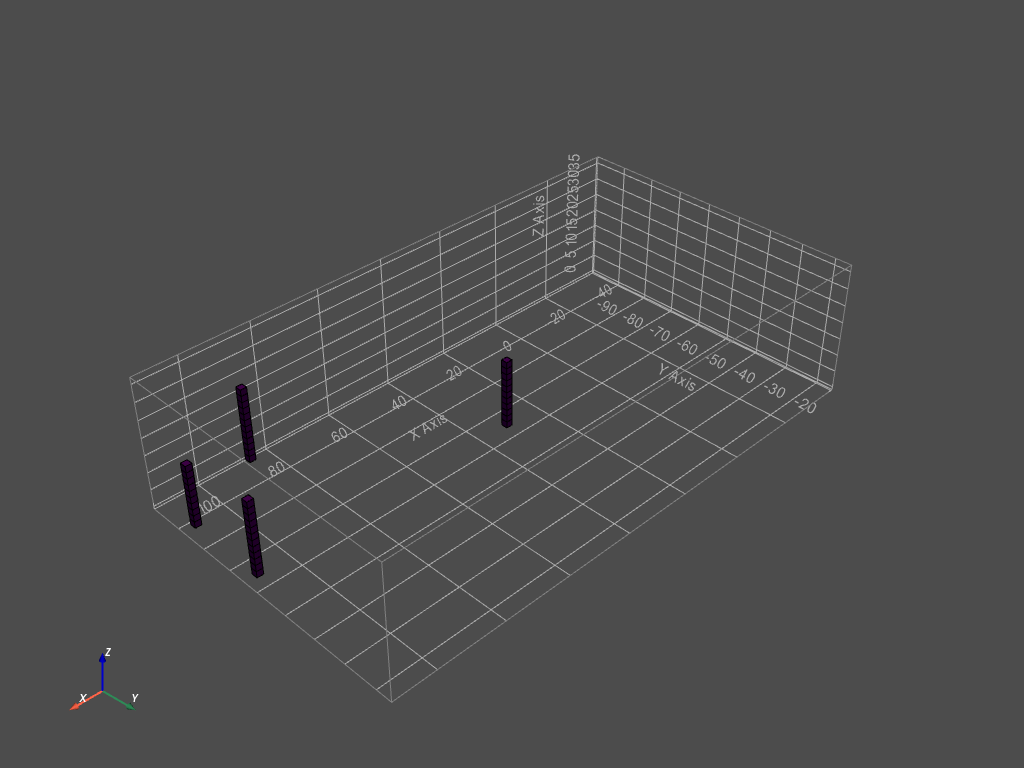

[(235.5051936291799, 141.90519277087301, 217.50519440404028),
 (36.0, -57.600000858306885, 18.000000774860382),
 (0.0, 0.0, 1.0)]

In [31]:
p = pv.Plotter(notebook=True)

base_lattice = trimmed_shaft_lattice

# Set the grid dimensions: shape + 1 because we want to inject our values on the CELL data
grid = pv.UniformGrid()
grid.dimensions = np.array(base_lattice.shape) + 1
# The bottom left corner of the data set
grid.origin = base_lattice.minbound - base_lattice.unit * 0.5
# These are the cell sizes along each axis
grid.spacing = base_lattice.unit 

# adding the boundingbox wireframe
p.add_mesh(grid.outline(), color="grey", label="Domain")

# adding the avilability lattice
# init_avail_lattice.fast_vis(p)

# adding axes
p.add_axes()
p.show_bounds(grid="back", location="back", color="#aaaaaa")




# Add the data values to the cell data
grid.cell_arrays["Agents"] = base_lattice.flatten(order="F").astype(int)  # Flatten the array!
# filtering the voxels
threshed = grid.threshold([0.9, agn_num - 0.9])
# adding the voxels
p.add_mesh(threshed, name='sphere', show_edges=True, opacity=1.0, show_scalar_bar=False)


# p.add_slider_widget(create_mesh, [0, n_frames], title='Time', value=0, event_type="always", style="classic", pointa=(0.1, 0.1), pointb=(0.9, 0.1))
p.show(use_ipyvtk=True)

#saving and plotting
png_path = os.path.relpath('../screenshots/6.3_shafts.png')
p.show(screenshot= png_path)

### 2.3. Saving lattice frames in CSV

In [37]:
# save the ground floor latice to csv 
csv_path = os.path.relpath('../data/shaft_lattice.csv')
trimmed_shaft_lattice.to_csv(csv_path)

import pickle
lattice_pickle_path = os.path.relpath('../data/shaft_lattice.p')
pickle.dump(trimmed_shaft_lattice, open(lattice_pickle_path,"wb"))

### Credits

In [ ]:
__author__ = "Shervin Azadi and Pirouz Nourian"
_Chief_editor_ =  "Maartje Damen"
_Co_editor_ = "Eda Akaltun"
_Co_editor_ = "Siebren Meines"
_editor_mentor_ = "Shervin Azadi"
__license__ = "MIT"
__version__ = "1.0"
__url__ = "https://github.com/shervinazadi/spatial_computing_workshops"
__summary__ = "Spatial Computing Design Studio Workshop on MCDA and Path Finding for Generative Spatial Relations"